In [32]:
import pandas as pd
import librosa
import os
import numpy as np


In [3]:
df = pd.read_csv('./data/results_wav.csv', sep=';')

df.head()

,title,region,keyword,duration,url,path,wav_path
0,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Jakarta,Kicir-Kicir asal Jakarta,3.54,https://www.youtube.com/watch?v=0wTJULU2REc&pp...,datasets/songs/kicir_kicir_lagu_dan_tari_nusan...,datasets/wav_songs/kicir_kicir_lagu_dan_tari_n...
1,KICIR KICIR | Lagu Daerah Jakarta (Betawi) | D...,Jakarta,Kicir-Kicir asal Jakarta,4.40,https://www.youtube.com/watch?v=LU3YHPgRxQo&pp...,datasets/songs/kicir_kicir_lagu_daerah_jakarta...,datasets/wav_songs/kicir_kicir_lagu_daerah_jak...
2,Kicir Kicir Jakarta,Jakarta,Kicir-Kicir asal Jakarta,3.52,https://www.youtube.com/watch?v=jMynoFKskhc&pp...,datasets/songs/kicir_kicir_jakarta.mp3,datasets/wav_songs/kicir_kicir_jakarta.wav
3,ONDEL ONDEL | Lagu Daerah DKI Jakarta - Betawi...,jakarta,Ondel Ondel asal jakarta,3.39,https://www.youtube.com/watch?v=wardyOl-EHo&pp...,datasets/songs/ondel_ondel_lagu_daerah_dki_jak...,datasets/wav_songs/ondel_ondel_lagu_daerah_dki...
4,ONDEL ONDEL 💞 LAGU DAERAH DKI JAKARTA | ONDEL ...,jakarta,Ondel Ondel asal jakarta,4.44,https://www.youtube.com/watch?v=_X39qcf41ZU&pp...,datasets/songs/ondel_ondel_lagu_daerah_dki_jak...,datasets/wav_songs/ondel_ondel_lagu_daerah_dki...


In [4]:
def get_duration(file_path):
    if file_path is None:
        print('skipping file path is None')
        return None, None
    
    y, sr = librosa.load(file_path)
    duration = librosa.get_duration(y=y, sr=sr)
    print(f'sample rate: {sr}, duration: {duration}')
    return sr, duration

In [5]:
df['sample_rate'], df['duration_sec'] = zip(*df['wav_path'].map(get_duration))


sample rate: 22050, duration: 233.89460317460316
sample rate: 22050, duration: 279.9397732426304
sample rate: 22050, duration: 231.29396825396825
sample rate: 22050, duration: 218.17469387755102
sample rate: 22050, duration: 283.39954648526077
sample rate: 22050, duration: 235.7986394557823
sample rate: 22050, duration: 233.08190476190475
sample rate: 22050, duration: 105.62757369614512


In [6]:
df.describe()

,duration,sample_rate,duration_sec
count,8.000000,8.0,8.000000
mean,3.481250,22050.0,227.651338
std,0.915867,0.0,54.732683
min,1.460000,22050.0,105.627574
25%,3.487500,22050.0,228.014150
50%,3.540000,22050.0,233.488254
75%,3.770000,22050.0,246.833923
max,4.440000,22050.0,283.399546


In [7]:
# import matplotlib.pyplot as plt

# for index, row in df.iterrows():
#     y, sr = librosa.load(row['wav_path'])
#     plt.figure(figsize=(10, 4))
#     librosa.display.waveshow(y, sr=sr)
#     plt.title(f"Waveform of {row['title']}")
#     plt.xlabel("Time (s)")
#     plt.ylabel("Amplitude")
#     plt.show()

In [21]:
import os
import re
from pydub import AudioSegment

def sanitize_filename(filename):
    """
    Removes or replaces invalid characters from a filename or folder name.
    """
    return re.sub(r'[<>:"/\\|?*]', '', filename)

def normalized_yt_title(title):
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

def split_audio(wav_path, output_dir, segment_duration=30):
    audio = AudioSegment.from_wav(wav_path)
    
    total_duration = len(audio) / 1000 
    
    num_segments = int(total_duration // segment_duration)
    
    os.makedirs(output_dir, exist_ok=True)
    
    for i in range(num_segments):
        start_time = i * segment_duration * 1000 
        end_time = (i + 1) * segment_duration * 1000 
        segment = audio[start_time:end_time]
        
        segment_file = os.path.join(output_dir, f"{os.path.basename(wav_path).replace('.wav', '')}segment{i + 1}.wav")
        segment.export(segment_file, format="wav")
        print(f"Saved segment {i + 1} at: {segment_file}")

- bikin variable split_result dengan value array kosong
- Loop df dan ambil wave_path
- jalanin function split audio ke 30s
- append hasil dari function split audio ke variable split_result

In [28]:
split_result = []

def split_songs_to_segments(df, output_base_folder='datasets/30s_segments'):
    for index, row in df.iterrows():
        wav_path = row['wav_path']
        title = row['title']
        region = row['region']
        keyword = row['keyword']
        
        norm_title = normalized_yt_title(title)
        norm_region = region.lower().replace(' ', '_')
        output_dir = os.path.join(output_base_folder, norm_region, norm_title)
        
        audio = AudioSegment.from_wav(wav_path)
        total_duration = len(audio) / 1000
        segment_duration = 30
        num_segments = int(total_duration // segment_duration)
        
        os.makedirs(output_dir, exist_ok=True)
        
        for i in range(num_segments):
            start_time = i * segment_duration * 1000
            end_time = (i + 1) * segment_duration * 1000
            segment = audio[start_time:end_time]
            
            segment_file = os.path.join(output_dir, f"{norm_title}_segment{i + 1}.wav")
            segment.export(segment_file, format="wav")
            
            split_result.append({
                'title': title,
                'region': region,
                'keyword': keyword,
                '30s_path': segment_file
            })
        print(f"Saved {num_segments} segments in {norm_region} for {title} at: {output_dir}")

In [29]:
split_songs_to_segments(df)

Saved 7 segments in jakarta for KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak at: datasets/30s_segments/jakarta/kicir_kicir_lagu_dan_tari_nusantara_lagu_anak
Saved 9 segments in jakarta for KICIR KICIR | Lagu Daerah Jakarta (Betawi) | Diva bernyanyi | Diva The Series Official at: datasets/30s_segments/jakarta/kicir_kicir_lagu_daerah_jakarta_betawi_diva_bernyanyi_diva_the_series_official
Saved 7 segments in jakarta for Kicir Kicir Jakarta at: datasets/30s_segments/jakarta/kicir_kicir_jakarta
Saved 7 segments in jakarta for ONDEL ONDEL | Lagu Daerah DKI Jakarta - Betawi | Budaya Indonesia | Dongeng Kita at: datasets/30s_segments/jakarta/ondel_ondel_lagu_daerah_dki_jakarta_betawi_budaya_indonesia_dongeng_kita
Saved 9 segments in jakarta for ONDEL ONDEL 💞 LAGU DAERAH DKI JAKARTA | ONDEL ONDEL BETAWI REMIX at: datasets/30s_segments/jakarta/ondel_ondel_lagu_daerah_dki_jakarta_ondel_ondel_betawi_remix
Saved 7 segments in jawa_barat for Lagu manuk dadali at: datasets/30s_segments/jawa_bara

In [31]:
df_res = pd.DataFrame(split_result)

In [34]:
def extract_mfcc_features(wav_path, n_mfcc=13):
    y, sr = librosa.load(wav_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

In [35]:
df_res['mfcc_features'] = df_res['30s_path'].apply(extract_mfcc_features)
df_res.head()

,title,region,keyword,30s_path,mfcc_features
0,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Jakarta,Kicir-Kicir asal Jakarta,datasets/30s_segments/jakarta/kicir_kicir_lagu...,"[-161.10701, 88.2896, -4.8944087, 21.922462, -..."
1,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Jakarta,Kicir-Kicir asal Jakarta,datasets/30s_segments/jakarta/kicir_kicir_lagu...,"[-83.09855, 94.346504, -21.865372, 32.208786, ..."
2,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Jakarta,Kicir-Kicir asal Jakarta,datasets/30s_segments/jakarta/kicir_kicir_lagu...,"[-89.93492, 92.994514, -17.861044, 36.76891, -..."
3,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Jakarta,Kicir-Kicir asal Jakarta,datasets/30s_segments/jakarta/kicir_kicir_lagu...,"[-97.85396, 97.05946, -6.5225873, 33.598427, -..."
4,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Jakarta,Kicir-Kicir asal Jakarta,datasets/30s_segments/jakarta/kicir_kicir_lagu...,"[-88.59536, 93.96856, -18.004303, 34.058342, -..."


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Prepare the data
X = np.array(df_res['mfcc_features'].tolist())
y = df_res['keyword']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

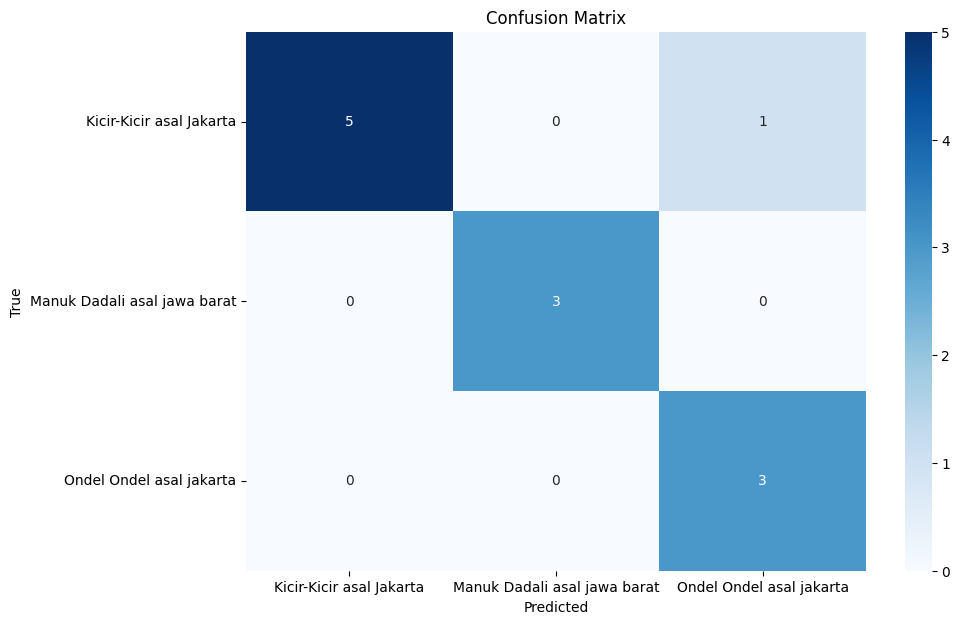

                              precision    recall  f1-score   support

    Kicir-Kicir asal Jakarta       1.00      0.83      0.91         6
Manuk Dadali asal jawa barat       1.00      1.00      1.00         3
    Ondel Ondel asal jakarta       0.75      1.00      0.86         3

                    accuracy                           0.92        12
                   macro avg       0.92      0.94      0.92        12
                weighted avg       0.94      0.92      0.92        12



In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=model.classes_))